# Maximizing Data Downlinked



In [1]:
# Standard imports
import sys
import os
from itertools import groupby

# Add the path to the folder containing the module
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

# Required imports
from common.sat_gen import make_tle
from common.station_gen import teleport_json
from common.utils import load_earth_data, gap_times_condense

import brahe as bh
import brahe.data_models as bdm
import brahe.access.access as ba
import numpy as np
import matplotlib.pyplot as plt
import json

# Pyomo imports
import pyomo.environ as pyo
import pyomo.kernel as pk

In [2]:


%matplotlib inline

# Setup info
load_earth_data('data/iau2000A_finals_ab.txt')

# Create a TLE
epc0 = bh.Epoch(2024, 5, 20, 0, 0, 0) # Epoch of orbital elements
epc1 = bh.Epoch(2024, 5, 21, 0, 0, 0) # End time for simulation
alt  = 550 # Altitude in km
ecc  = 0.01 # Eccentricity
inc  = 53 # Inclination in degrees
raan = 15 # Right Ascension of the Ascending Node in degrees
argp = 30 # Argument of Perigee in degrees
M    = 45 # Mean Anomaly in degrees
norad_id = 99999 # NORAD ID placeholder

tle = make_tle(epc0, alt, ecc, inc, raan, argp, M, norad_id=norad_id)
print(f'Our TLE looks like:\n {tle.line1}\n {tle.line2}\n')

sat1 = bdm.Spacecraft(
    id=99999,
    name="Sat1",
    line1=tle.line1,
    line2=tle.line2,
)

Download complete
Loading the latest Earth Orientation Data
Our TLE looks like:
 1 99999U          24141.00000000  .00000000  00000-0  00000-0 0    00
 2 99999  53.0000  15.0000 0100000  30.0000  45.0000 15.05490874    07



In [3]:
# Load ground stations from JSON file
ground_stations = teleport_json('data/teleport_locations.json')
print(f"Loaded {len(ground_stations)} ground stations")
ground_stations = ground_stations[0:50]  # Using first 20 stations

Loaded 915 ground stations


In [4]:
model = pk.block()
# Load original station data from JSON
with open('data/teleport_locations.json', 'r') as f:
    stations_data = json.load(f)

# Get contacts for each station
station_contacts = {}
data_rate = 10  # Mbps (example value)
for i, station in enumerate(ground_stations):
    contacts = ba.find_location_accesses(sat1, station, epc0, epc1)
    # Calculate data volume for each contact
    data_volumes = [(contact.t_end - contact.t_start).total_seconds() * data_rate for contact in contacts]
    station_contacts[i] = {
        'contacts': contacts,
        'station': station,
        'name': stations_data[i]['name'],  # Get name from original JSON
        'data_volumes': data_volumes,
        'total_data': sum(data_volumes)
    }

# Create binary variables for station selection
model.x = pk.variable_dict()
for i in range(len(ground_stations)):
    model.x[i] = pk.variable(domain=pk.Binary)

# Create constraints list
model.constraints = pk.constraint_list()

# Constraint for exact number of stations
MAX_STATIONS = 5
model.constraints.append(pk.constraint(sum(model.x.values()) == MAX_STATIONS))

# Create variable for total data volume
model.total_data = pk.variable(domain=pk.NonNegativeReals)

# Calculate total data volume expression
total_data_expr = sum(station_contacts[i]['total_data'] * model.x[i] for i in range(len(ground_stations)))

# Set total data constraint
model.constraints.append(pk.constraint(model.total_data == total_data_expr))

# Create and attach objective to model - maximize total data
model.obj = pk.objective(model.total_data, sense=pk.maximize)

# Create solver using SolverFactory
from pyomo.opt import SolverFactory
solver = SolverFactory('gurobi')

# Solve
solver.solve(model)

# Print results
selected_stations = []
total_data = 0
print("\nSelected stations and their data volumes:")
for i in model.x:
    if model.x[i].value > 0.5:
        selected_stations.append(i)
        station_data = station_contacts[i]['total_data']
        total_data += station_data
        print(f"Station {i} ({station_contacts[i]['name']}): {station_data:.2f} Megabits")
        
print(f"\nTotal data volume: {total_data:.2f} Megabits")




Selected stations and their data volumes:
Station 6 (Telstra Gnangara (Perth) Teleport): 49784.07 Megabits
Station 30 (COMSAT Santa Paula Teleport): 51355.83 Megabits
Station 35 (Intelsat Napa Teleport): 54005.51 Megabits
Station 36 (Intelsat Riverside Teleport): 50158.37 Megabits
Station 49 (Speedcast Mawson Lakes Teleport (Adelaide)): 50863.29 Megabits

Total data volume: 256167.08 Megabits


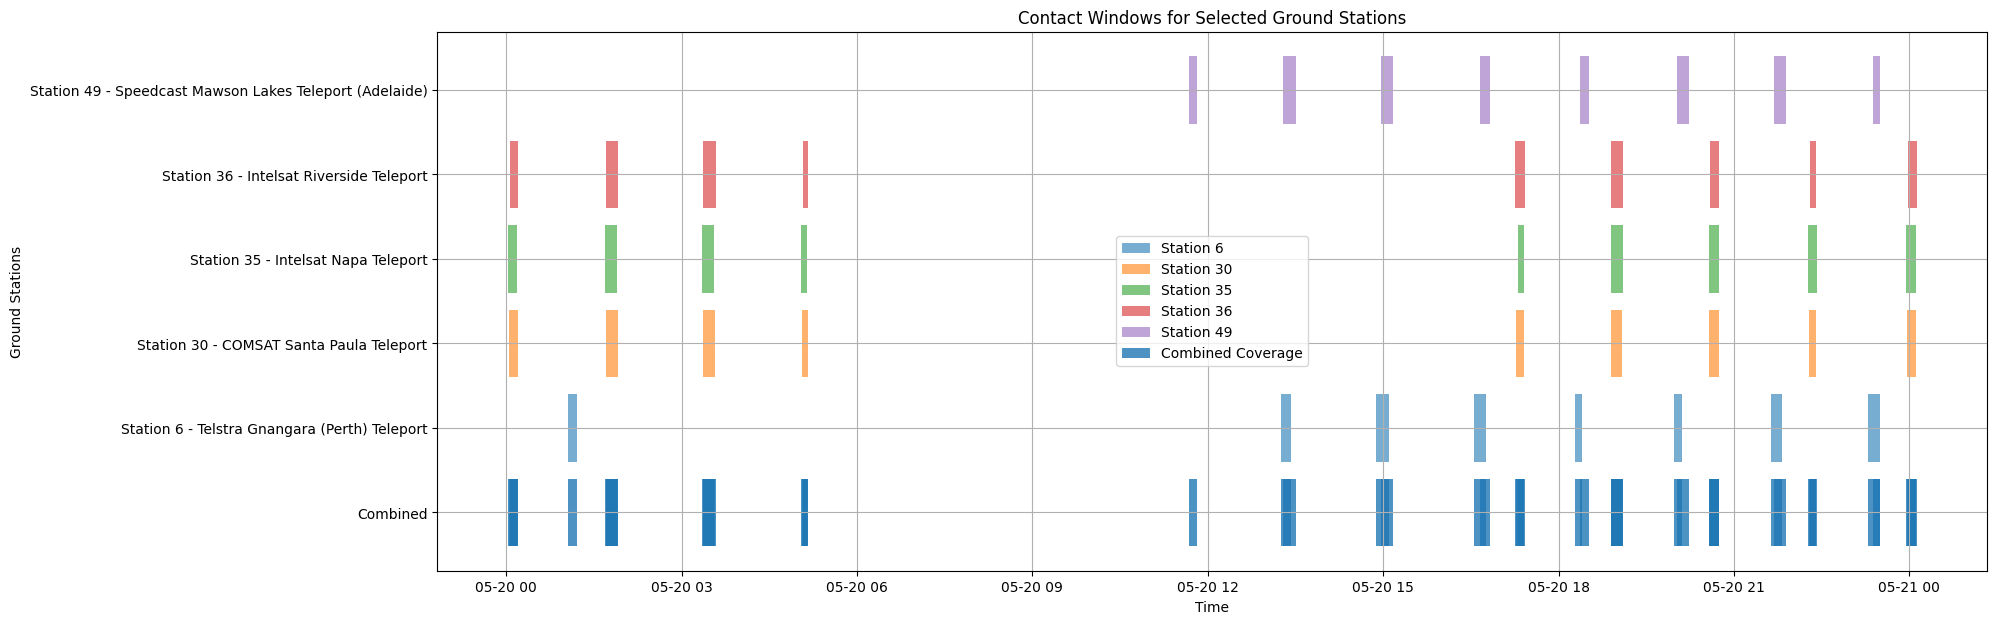

In [5]:
# Create visualization
fig, ax = plt.subplots(figsize=(20,7))

# Plot contacts for individual selected stations
for idx, station_id in enumerate(selected_stations):
    contacts = station_contacts[station_id]['contacts']
    station_name = station_contacts[station_id]['name']
    ax.broken_barh([(contact.t_start, contact.t_end-contact.t_start) 
                    for contact in contacts],
                    (idx + 1, 0.8),  # Shifted up by 1 to make room for combined view
                    facecolors=f'C{idx}',
                    alpha=0.6,
                    label=f'Station {station_id}')

# Plot combined contacts at the bottom
selected_contacts = []
for station_id in selected_stations:
    selected_contacts.extend(station_contacts[station_id]['contacts'])

# Sort contacts by start time
sorted_contacts = sorted(selected_contacts, key=lambda x: x.t_start)

# Plot the actual contact windows for combined view
ax.broken_barh([(contact.t_start, contact.t_end-contact.t_start) 
                for contact in sorted_contacts],
                (0, 0.8),  # At the bottom
                facecolors='tab:blue',  # Single solid color
                alpha=0.8,
                label='Combined Coverage')

# Update y-axis ticks with station ID and name
ax.set_yticks([0.4] + [i + 1.4 for i in range(len(selected_stations))])
ax.set_yticklabels(['Combined'] + [f'Station {sid} - {station_contacts[sid]["name"]}' 
                                  for sid in selected_stations])

plt.ylabel("Ground Stations")
plt.xlabel("Time")
plt.title("Contact Windows for Selected Ground Stations")
plt.legend()
plt.grid(True)
plt.show()